<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/nisar/Subsidence_NISAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# NISAR Application: Subsidence

### Corresponding Story Map: https://arcg.is/0PGi5f0
### NISAR White Paper:

### I. How to create SAR quicklook images of subsidence?

* Useful Products: The technique of SAR interferometry (InSAR) is useful for detecting and monitoring subsidence. Specifically, InSAR phase, InSAR coherence, and sequences of SAR images for time series analysis to measure subsidence rates over time.

* Useful Wavelengths: For subsidence, longer wavelengths such as L-band (wavelength around 23.6 cm) and P-band (wavelength around 68 cm) are often preferred because they can penetrate vegetation and soil cover to some extent, providing information about subsurface deformation. These longer wavelengths are suitable for monitoring large-scale subsidence over broad areas. However, shorter wavelengths such as C-band (wavelength around 5.6 cm) and X-band (wavelength around 3 cm) are also useful for SAR monitoring due to their higher spatial resolution. While they may not penetrate as deeply into the ground, they offer better detection of small-scale deformations and surface features, which can be crucial for urban areas or regions with complex surface conditions.

* Instructions to View: repeating color scale

### II. How to interpret SAR images of subsidence?

Interpreting InSAR (Interferometric Synthetic Aperture Radar) images of subsidence involves analyzing the interferometric phase information to identify and quantify surface deformation associated with subsidence.

* InSAR Phase:
  * InSAR measures the phase difference between two SAR images acquired at different times. Changes in the interferometric phase represent changes in the distance between the SAR sensor and the ground surface along the radar line of sight (LOS).
  * Phase fringes in InSAR images represent changes in surface elevation or displacement.
  * Depending on fringe direction, fringes indicate areas that have moved closer to the radar sensor (i.e., subsidence) or indicate areas that have moved farther away from the radar sensor (i.e., uplift).

* Quantify Subsidence Magnitude:
  * Count the number of phase fringes to estimate the magnitude of subsidence. Each fringe corresponds to half the wavelength of the radar signal (e.g., for C-band SAR, approximately 2.8 cm).
  * Convert fringe counts to subsidence values by multiplying the number of fringes by half the wavelength.

* Validate with Ground Truth Data:
  * Validate InSAR-derived subsidence measurements with ground truth data, such as GPS surveys, leveling measurements, or historical records of subsidence.

* Temporal Analysis:
  * Analyze temporal sequences of InSAR images to track the evolution of subsidence over time.

* Integration with Other Data Sources:
  * Integrate InSAR data with other data sources, such as geological maps, land use/land cover data, and hydrological information, to contextualize subsidence observations and identify contributing factors.
  * Consider environmental factors such as land use, groundwater extraction, and soil properties, which can contribute to subsidence processes.

## SAR Examples: California Oil Fields


The content of this notebook is as follows:

1. [Running the Notebook](#s1)
2. [California Oil Fields](#s2)
3. [New Orleans Subsidence](#s3)
4. [Earthquake](#s4)
6. [References](#s6)



<a name="s1"></a>
## 1. Running the Notebook

- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**.

### Install Python Packages
This routine uses several python libaries. Some are already included in the Google Colab environment and others are installed and imported in the cell below. Downloading new python packages to this environment may take a few seconds to complete.

In [5]:
!pip install rasterio --quiet
!pip install geopandas --quiet

import rasterio as rio                      # Read and write geospatial raster data
from rasterio.plot import plotting_extent   # Returns plotting extent in format needed
import matplotlib.pyplot as plt             # Plotting, making graphs
import geopandas as gpd                     # Visualizing and importing geodata frames
import numpy as np                          # Numeric and mathematic functions
import math                                 # Access to mathematical functions
import getpass
import os
from osgeo import gdal
import glob

##### Install GDAL dependencies to Google Colab

In [6]:
!%%shell
!yes | add-apt-repository ppa:ubuntugis/ppa
!apt-get update
!apt-get install gdal-bin libgdal-dev
!C_INCLUDE_PATH=/usr/include/gdal CPLUS_INCLUDE_PATH=/usr/include/gdal python -m pip install GDAL=="$(gdal-config --version)"

/bin/bash: line 1: fg: no job control
PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 6B827C12C2D425E227EDCA75089EBE08314DF160
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_

### Download the Data

Fetch UAVSAR geotiffs from the download links below with wget. The original UAVSAR data have been converted to cropped and subset geotiffs over the Station Fire perimeter.


In [39]:
# Enter NASA's Earth data login
username = getpass.getpass(prompt='Earthdata username:')
password = getpass.getpass(prompt='Earthdata password:')

Earthdata username:··········
Earthdata password:··········


In [40]:
# California Oil Fields
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_23007_09084-010_10083-013_0401d_s01_L090_01/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.ann --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_23007_09084-010_10083-013_0401d_s01_L090_01/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_23007_09084-010_10083-013_0401d_s01_L090_01/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.unw.grd --quiet

# New Orleans Subsidence
# (No unwrapped data)
# !wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_gulfco_09010_09044-002_12053-006_1112d_s01_L090_02/gulfco_09010_09044-002_12053-006_1112d_s01_L090HH_02.ann --quiet
# !wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_gulfco_09010_09044-002_12053-006_1112d_s01_L090_02/gulfco_09010_09044-002_12053-006_1112d_s01_L090HH_02.int.grd --quiet
# !wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_gulfco_09010_09044-002_12053-006_1112d_s01_L090_02/gulfco_09010_09044-002_12053-006_1112d_s01_L090HH_02.unw.grd --quiet

!wget --user {username} --password {password} https://uavsar.asfdaac.alaska.edu/UA_gulfco_09010_09044-002_09067-000_0079d_s01_L090_02/gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02.ann --quiet
!wget --user {username} --password {password} https://uavsar.asfdaac.alaska.edu/UA_gulfco_09010_09044-002_09067-000_0079d_s01_L090_02/gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02.int.grd --quiet
!wget --user {username} --password {password} https://uavsar.asfdaac.alaska.edu/UA_gulfco_09010_09044-002_09067-000_0079d_s01_L090_02/gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02.unw.grd --quiet

# Baja Earthquake
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_26501_09083-010_10028-000_0174d_s01_L090_03/SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03.int.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_26501_09083-010_10028-000_0174d_s01_L090_03/SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03.unw.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_26501_09083-010_10028-000_0174d_s01_L090_03/SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03.ann --quiet


In [41]:
# Clone the script to generate UAVSAR HDR files
!git clone https://bitbucket.org/nathanmthomas/bucket-of-rs-and-gis-scripts/src/master/BuildUAVSARhdr.py

Cloning into 'BuildUAVSARhdr.py'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 229 (delta 120), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (229/229), 50.10 KiB | 305.00 KiB/s, done.
Resolving deltas: 100% (120/120), done.


In [42]:
# View script options
!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -h

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

usage: BuildUAVSARhdr.py [-h] [-i INPUT] [-r UAVSAR] [-p POLARIZATION]

options:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        Specify the input UAVSAR ann file
  -r UAVSAR, --uavsar UAVSAR
                        Specify the input UAVSAR radar file
  -p POLARIZATION, --polarization POLARIZATION
                        Specify the input UAVSAR polarization in UPPERCASE (i.e HHHV, HHHH, VVVV,
                        AMP1, AMP2, COR, UNW, HGT, INT)


In [1]:
## Run the HDR script for all the GRD annd annotation files in the directory
int_polarization = 'INT'
unw_polarization = 'UNW'

## California subsidence
annotation_file = 'SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.ann'
int_file = 'SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd'
unw_file = 'SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.unw.grd'

!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {int_file} -p {int_polarization}
!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {unw_file} -p {unw_polarization}

## New Orleans subsidence
# annotation_file = 'gulfco_09010_09044-002_12053-006_1112d_s01_L090HH_02.ann'
# int_file = 'gulfco_09010_09044-002_12053-006_1112d_s01_L090HH_02.int.grd'
# unw_file = 'gulfco_09010_09044-002_12053-006_1112d_s01_L090HH_02.unw.grd'

annotation_file = 'gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02.ann'
int_file = 'gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02.int.grd'
unw_file = 'gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02.unw.grd'

!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {int_file} -p {int_polarization}
!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {unw_file} -p {unw_polarization}

## Baja California earthquake
annotation_file = 'SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03.ann'
int_file = 'SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03.int.grd'
unw_file = 'SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03.unw.grd'

!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {int_file} -p {int_polarization}
!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {unw_file} -p {unw_polarization}

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

UPPER LEFT LAT =  35.65563000
UPPER LEFT LONG =  -120.61042584
SAMPLES = 15416
Lines = 19578
PIXEL SIZE =  5.556e-05
DATATYPE =  6
SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd.hdr
Writing output HDR file...
Output HDR file = SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd.hdr

Thank you for using UAVSAR.py

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
U

In [2]:
## Function to process .int.grd Files
def process_int_files(input_dir, output_dir, filename_string, window, projection):
  """
  Function to take all the GRD files in the input directory and save as geotiffs.
  Can set new extents and projections for the output geotiff.
  """
  grd_files = [file for file in os.listdir(input_dir) if file.endswith('.int.grd') and file.startswith(filename_string)]
  for grd_file in grd_files:
    input_path = os.path.join(input_dir, grd_file)
    print(input_path)
    output_path = os.path.join(output_dir, grd_file.replace('.int.grd', '_int_clipped.tif'))
    print(output_path)
    gdal.Warp(output_path, input_path, format='GTiff', outputBounds=window, dstSRS=projection)

## Function to process .unw.grd Files
def process_unw_files(input_dir, output_dir, filename_string, window, projection):
  """
  Function to take all the GRD files in the input directory and save as geotiffs.
  Can set new extents and projections for the output geotiff.
  """
  grd_files = [file for file in os.listdir(input_dir) if file.endswith('.unw.grd') and file.startswith(filename_string)]
  for grd_file in grd_files:
    input_path = os.path.join(input_dir, grd_file)
    print(input_path)
    output_path = os.path.join(output_dir, grd_file.replace('.unw.grd', '_unw_clipped.tif'))
    print(output_path)
    gdal.Warp(output_path, input_path, format='GTiff', outputBounds=window, dstSRS=projection)

# Define input directory and output directory
input_directory = '/content'  # Directory containing GRD and INC files
output_directory = '/content'  # Directory to save processed files

# 2. California Oil Fields

Plot UAVSAR interferogram

Data page: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_23007_09084-010_10083-013_0401d_s01_L090_01#data

In [3]:
# Define extent and projection details
upper_left_x = -119.884 #xmin
upper_left_y = 35.564 #ymind
lower_right_x = -119.587
lower_right_y = 35.395
window = (upper_left_x, upper_left_y, lower_right_x, lower_right_y)
projection = 'EPSG:4326'

In [7]:
# Process int files
process_int_files(input_directory, output_directory, 'SanAnd_23007', window, projection)

# Process unw files
process_unw_files(input_directory, output_directory, 'SanAnd_23007', window, projection)

/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd
/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01_int_clipped.tif
/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.unw.grd
/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01_unw_clipped.tif


In [8]:
grd_int = rio.open('/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01_int_clipped.tif')
grd_int = grd_int.read(1)
grd_int[grd_int == 0] = np.nan #set 0 to nan
print(np.nanmin(grd_int), 'interferogram min value')
print(np.nanmax(grd_int), 'interferogram max value')

magnitude = np.abs(grd_int)
phase = np.angle(grd_int)
print(np.nanmin(magnitude), 'magnitude min value')
print(np.nanmax(magnitude), 'magnitude max value')

print(np.nanmin(phase), 'phase min value')
print(np.nanmax(phase), 'phase max value')

(-4.9592204+0.67435956j) interferogram min value
(4.316325+3.4799514j) interferogram max value
2.501534e-10 magnitude min value
65.33985 magnitude max value
-3.1415925 phase min value
3.141592 phase max value


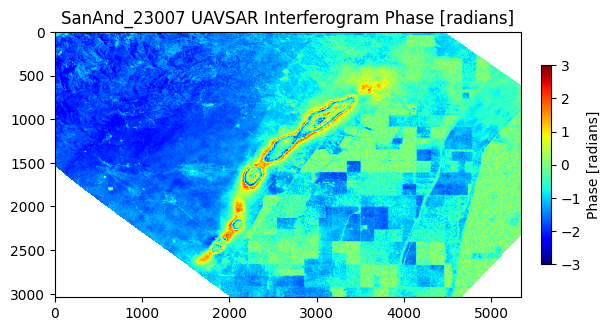

In [9]:
plt.imshow(phase, vmin=-3, vmax=3, cmap='jet')
plt.title('SanAnd_23007 UAVSAR Interferogram Phase [radians]')
plt.colorbar(label='Phase [radians]', fraction=0.02, pad=0.04)
plt.show()

Plot unwrapped interferogram

In [10]:
grd_unw = rio.open('/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01_unw_clipped.tif')
grd_unw = grd_unw.read(1)
grd_unw[grd_unw == 0] = np.nan #set 0 to nan
print(np.nanmin(grd_unw), 'unwrapped int min value')
print(np.nanmax(grd_unw), 'unwrapped int max value')

-10.024221 unwrapped int min value
17.17127 unwrapped int max value


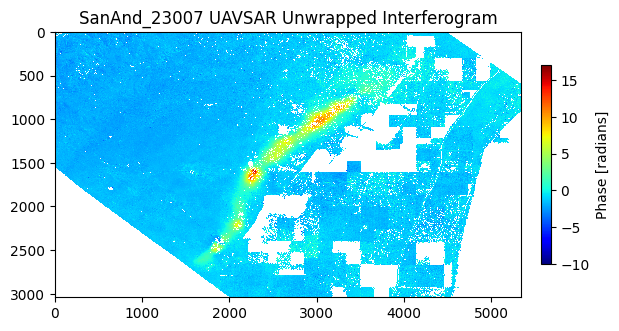

In [11]:
plt.imshow(grd_unw, interpolation='nearest',vmin=-10, vmax=17, cmap='jet')
plt.title('SanAnd_23007 UAVSAR Unwrapped Interferogram')
plt.colorbar(label='Phase [radians]', fraction=0.02, pad=0.04)
plt.show()

Convert to line of sight displacement

In [13]:
phase = grd_unw
wavelength = 25 #in cm
los_displacement = phase * (wavelength / (4 * np.pi))

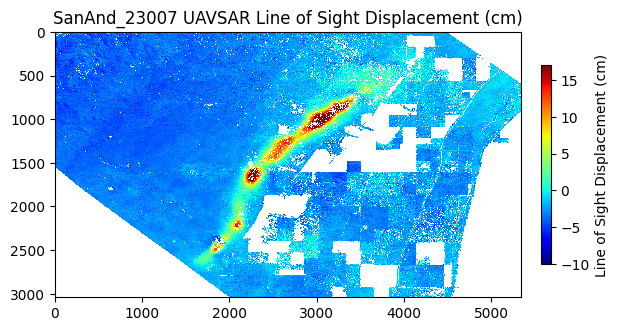

In [15]:
plt.imshow(los_displacement, interpolation='nearest', vmin=-10, vmax=17, cmap='jet')
plt.title('SanAnd_23007 UAVSAR Line of Sight Displacement (cm)')
plt.colorbar(label='Line of Sight Displacement (cm)', fraction=0.02, pad=0.04)
plt.show()

# 3. New Orleans Subsidence

UAVSAR Data Line: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=gulfco_09010_09044-002_12053-006_1112d_s01_L090_02#data
Reference: https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2015JB012636

Levee System Map: https://levees.sec.usace.army.mil/map-viewer/index.html?x=-90.208&y=29.97&z=12

Pairs with unwrapped data:
* https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=gulfco_09010_13133-000_13162-005_0097d_s01_L090_01#data
* https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=gulfco_09010_12053-006_12115-010_0116d_s01_L090_01#data
* https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=gulfco_09010_10009-004_11038-001_0514d_s01_L090_01#data
* https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=gulfco_09010_09044-002_09067-000_0079d_s01_L090_02#data
* https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=gulfco_09010_09044-002_09067-000_0079d_s01_L090_01#data
* https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=gulfco_09010_09044-002_10009-004_0223d_s01_L090_02#data
* https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=gulfco_09010_09044-002_10009-004_0223d_s01_L090_01#data

In [42]:
## Levee Maps
import requests
import matplotlib.pyplot as plt

# Make a GET request to fetch data
response = requests.get("levees.sec.usace.army.mil:443/api-local/")
print(response)
# Parse JSON response
data = response.json()

# Extract relevant data and plot (example)
x_values = [item['x'] for item in data['features']]
y_values = [item['y'] for item in data['features']]
plt.plot(x_values, y_values, 'ro')  # Example plot, adjust as needed
plt.show()

InvalidSchema: No connection adapters were found for 'levees.sec.usace.army.mil:443/api-local/'

In [16]:
# Define extent and projection details
upper_left_x = -90.5825 #xmin
upper_left_y = 30.073333 #ymind
lower_right_x = -89.745278
lower_right_y = 29.891667
window = (upper_left_x, upper_left_y, lower_right_x, lower_right_y)
projection = 'EPSG:4326'

In [17]:
# Process int files
process_int_files(input_directory, output_directory, 'gulfco_09010', window, projection)

# Process unw files
process_unw_files(input_directory, output_directory, 'gulfco_09010', window, projection)

/content/gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02.int.grd
/content/gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02_int_clipped.tif
/content/gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02.unw.grd
/content/gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02_unw_clipped.tif


In [18]:
grd_int = rio.open('gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02_int_clipped.tif')
grd_int = grd_int.read(1)
grd_int[grd_int == 0] = np.nan #set 0 to nan
print(np.nanmin(grd_int), 'interferogram min value')
print(np.nanmax(grd_int), 'interferogram max value')

magnitude = np.abs(grd_int)
phase = np.angle(grd_int)
print(np.nanmin(magnitude), 'magnitude min value')
print(np.nanmax(magnitude), 'magnitude max value')

print(np.nanmin(phase), 'phase min value')
print(np.nanmax(phase), 'phase max value')

(-9368.279+7248.2754j) interferogram min value
(7019.9785-2935.3071j) interferogram max value
2.9060146e-07 magnitude min value
39372.055 magnitude max value
-3.1415915 phase min value
3.1415923 phase max value


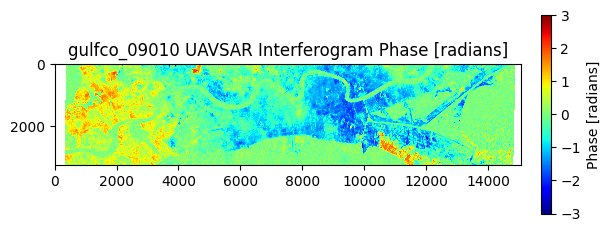

In [19]:
plt.imshow(phase, vmin=-3, vmax=3, cmap='jet')
plt.title('gulfco_09010 UAVSAR Interferogram Phase [radians]')
plt.colorbar(label='Phase [radians]', fraction=0.02, pad=0.04)
plt.show()

Plot unwrapped interferogram

In [20]:
grd_unw = rio.open('gulfco_09010_09044-002_09067-000_0079d_s01_L090HH_02_unw_clipped.tif')
grd_unw = grd_unw.read(1)
grd_unw[grd_unw == 0] = np.nan #set 0 to nan
print(np.nanmin(grd_unw), 'unwrapped int min value')
print(np.nanmax(grd_unw), 'unwrapped int max value')

-27.971575 unwrapped int min value
25.436583 unwrapped int max value


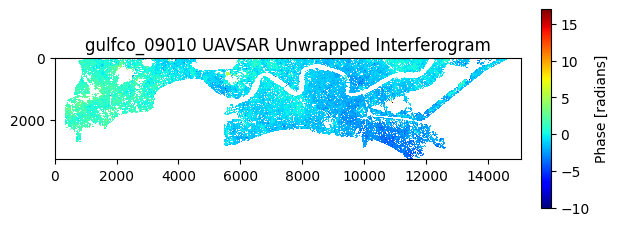

In [21]:
plt.imshow(grd_unw, interpolation='nearest', vmin=-10, vmax=17, cmap='jet')
plt.title('gulfco_09010 UAVSAR Unwrapped Interferogram')
plt.colorbar(label='Phase [radians]', fraction=0.02, pad=0.04)
plt.show()

Convert to line of sight displacement

In [22]:
phase = grd_unw
wavelength = 25 #in cm
los_displacement = phase * (wavelength / (4 * np.pi))

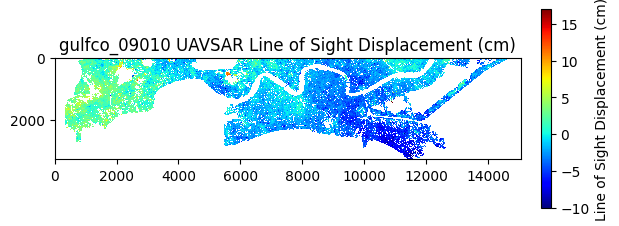

In [24]:
plt.imshow(los_displacement, interpolation='nearest', vmin=-10, vmax=17, cmap='jet')
plt.title('gulfco_09010 UAVSAR Line of Sight Displacement (cm)')
plt.colorbar(label='Line of Sight Displacement (cm)', fraction=0.02, pad=0.04)
plt.show()

# 4. Baja California Earthquake
UAVSAR Data Line: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_26501_09083-010_10028-000_0174d_s01_L090_03#data

Reference: https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2013GC005120

In [25]:
# Define extent and projection details
upper_left_x = -116.140833 #xmin
upper_left_y = 32.806667 #ymind
lower_right_x = -115.370278
lower_right_y = 32.689167
window = (upper_left_x, upper_left_y, lower_right_x, lower_right_y)
projection = 'EPSG:4326'

In [26]:
# Process int files
process_int_files(input_directory, output_directory, 'SanAnd_26501', window, projection)

# Process unw files
process_unw_files(input_directory, output_directory, 'SanAnd_26501', window, projection)

/content/SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03.int.grd
/content/SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03_int_clipped.tif
/content/SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03.unw.grd
/content/SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03_unw_clipped.tif


In [27]:
grd_int = rio.open('SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03_int_clipped.tif')
grd_int = grd_int.read(1)
grd_int[grd_int == 0] = np.nan #set 0 to nan
print(np.nanmin(grd_int), 'interferogram min value')
print(np.nanmax(grd_int), 'interferogram max value')

magnitude = np.abs(grd_int)
phase = np.angle(grd_int)
print(np.nanmin(magnitude), 'magnitude min value')
print(np.nanmax(magnitude), 'magnitude max value')

print(np.nanmin(phase), 'phase min value')
print(np.nanmax(phase), 'phase max value')

(-1689.886-1307.8474j) interferogram min value
(1506.7739+613.3271j) interferogram max value
9.481135e-07 magnitude min value
2136.862 magnitude max value
-3.1415923 phase min value
3.1415925 phase max value


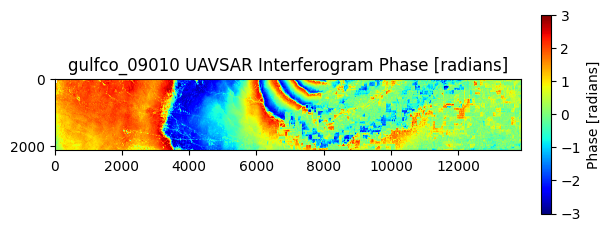

In [28]:
plt.imshow(phase, vmin=-3, vmax=3, cmap='jet')
plt.title('gulfco_09010 UAVSAR Interferogram Phase [radians]')
plt.colorbar(label='Phase [radians]', fraction=0.02, pad=0.04)
plt.show()

In [29]:
grd_unw = rio.open('SanAnd_26501_09083-010_10028-000_0174d_s01_L090HH_03_unw_clipped.tif')
grd_unw = grd_unw.read(1)
grd_unw[grd_unw == 0] = np.nan #set 0 to nan
print(np.nanmin(grd_unw), 'unwrapped int min value')
print(np.nanmax(grd_unw), 'unwrapped int max value')

-13.921854 unwrapped int min value
21.32417 unwrapped int max value


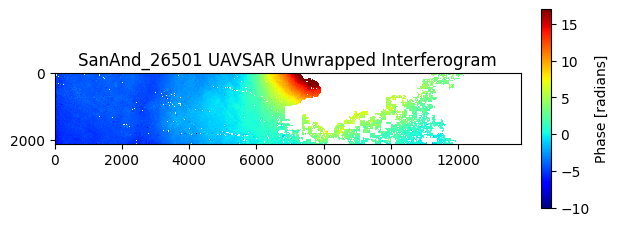

In [33]:
plt.imshow(grd_unw, interpolation='nearest',vmin=-10, vmax=17, cmap='jet')
plt.title('SanAnd_26501 UAVSAR Unwrapped Interferogram')
plt.colorbar(label='Phase [radians]', fraction=0.02, pad=0.04)
plt.show()

Convert to line of sight displacement

In [31]:
phase = grd_unw
wavelength = 25 #in cm
los_displacement = phase * (wavelength / (4 * np.pi))

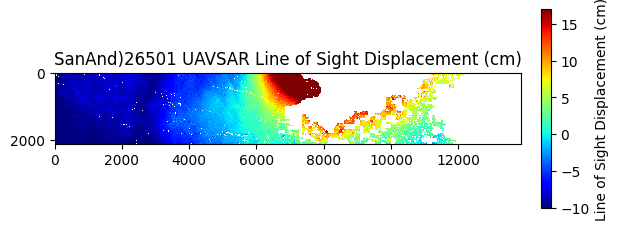

In [34]:
plt.imshow(los_displacement, interpolation='nearest',vmin=-10, vmax=17, cmap='jet')
plt.title('SanAnd)26501 UAVSAR Line of Sight Displacement (cm)')
plt.colorbar(label='Line of Sight Displacement (cm)', fraction=0.02, pad=0.04)
plt.show()

## Other Resources

UAVSAR Data Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

## References



1. Jones, C. E., An, K., Blom, R. G., Kent, J. D., Ivins, E. R., &amp; Bekaert, D. (2016). Anthropogenic and geologic influences on subsidence in the vicinity of New Orleans, Louisiana. Journal of Geophysical Research: Solid Earth, 121(5), 3867–3887. https://doi.org/10.1002/2015jb012636

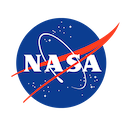

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2024. California Institute of Technology. Government sponsorship acknowledged.